<a href="https://colab.research.google.com/github/DavidSenseman/BIO1173/blob/main/Class_06_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------
**COPYRIGHT NOTICE:** This Jupyterlab Notebook is a Derivative work of [Jeff Heaton](https://github.com/jeffheaton) licensed under the Apache License, Version 2.0 (the "License"); You may not use this file except in compliance with the License. You may obtain a copy of the License at

> [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

------------------------

# **BIO 1173: Intro Computational Biology**

##### **Module 6: Advanced Topics**

* Instructor: [David Senseman](mailto:David.Senseman@utsa.edu), [Department of Biology, Health and the Environment](https://sciences.utsa.edu/bhe/), [UTSA](https://www.utsa.edu/)

### Module 6 Material

* Part 6.1: Reinforcement Learning
* Part 6.2: ONNX Runtime Environment
* Part 6.3: TBA
* **Part 6.4: Analysis of DICOM images with Pytorch**

#### **Change your Runtime Now!**

For this lesson you must have a good **GPU** hardware accelerator like the `A-100`.

## Google CoLab Instructions

You MUST run the following code cell to get credit for this class lesson. By running this code cell, you will map your GDrive to /content/drive and print out your Google GMAIL address. Your Instructor will use your GMAIL address to verify the author of this class lesson.

In [1]:
# You must run this cell first
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    from google.colab import auth
    auth.authenticate_user()
    COLAB = True
    print("Note: Using Google CoLab")
    import requests
    gcloud_token = !gcloud auth print-access-token
    gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
    print(gcloud_tokeninfo['email'])
except:
    print("**WARNING**: Your GMAIL address was **not** printed in the output below.")
    print("**WARNING**: You will NOT receive credit for this lesson.")
    COLAB = False

Mounted at /content/drive
Note: Using Google CoLab
david.senseman@gmail.com


You should see the following output except your GMAIL address should appear on the last line.

![__](https://biologicslab.co/BIO1173/images/class_04/class_04_1_image01B.png)

If your GMAIL address does not appear your lesson will **not** be graded.

## Accelerated Run-time Check

You MUST run the following code cell to get credit for this class lesson. The code in this cell checks what hardware acceleration you are using. To run this lesson, you must be running a Graphics Processing Unit (GPU) such as the `A100`.

In [2]:
# You must run this cell second

import tensorflow as tf

def check_device():
    # List all the *physical* devices TensorFlow can see
    devices = tf.config.list_physical_devices()

    # Flags we’ll set
    cpu  = False
    gpu  = False
    tpu  = False

    for d in devices:
        if d.device_type == 'CPU':
            cpu = True
        elif d.device_type == 'GPU':
            gpu = True
        elif d.device_type == 'TPU':
            tpu = True

    # -----------------------------------------------------------------
    # Report
    # -----------------------------------------------------------------
    if tpu:
        print("**Running on a TPU**")
        print("Your assignment requires a GPU – please switch your runtime.")
    elif gpu:
        print("**Running on a GPU**")
        print("You are good to go!")
        try:
            gpu_info = !nvidia-smi
            print('\n'.join(gpu_info))
        except Exception as e:
            print(f"Could not fetch GPU details: {e}")
    elif cpu:
        print("**Running on a CPU** – a GPU is required for this assignment.")
    else:
        print("No compatible accelerator found.")
        print("Please enable a GPU in Runtime > Change runtime type.")

# Run it
check_device()

**Running on a GPU**
You are good to go!
Sat Sep 27 22:08:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   35C    P0             52W /  400W |       5MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+------

If the code is correct you should see the following output

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_2_image01C.png)

### Create Custom Function

Run the code in the next cell to create the custom timing function.

In [3]:
# Simple function to print out elapsed time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

### Install Packages

Run the cell below to install the various packages needed for this lesson.

In [4]:
!pip install -q pydicom
!pip install -q dropblock

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 88.2 MB/s eta 0:00:00


If the code is correct you should see the following output

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_4_image02A.png)

# **Pneumonia Dectection from DICOM Image Analysis**

In this lesson will introduce the following advanced techniques that have not been covered so far in this course:

* **1. DICOM Image analysis**

* **2. _Lazy_ Loading of image data**

* **3. Training Deep Neural Neural Networks using `PyTorch`**

The images to be analyzed in this lesson are a subset of the NIH Chest‑X‑Ray‑8 (CXR‑8) dataset (https://data.nih.gov). This subset consisting of `9937` images in **DICOM format** that are frontal-view chest-X-rays. Each image is a single‑channel (grayscale) image of roughly 1024 × 1024 pixels.

![__](https://biologicslab.co/BIO1173/images/class_06/DICOM_Images.png)
**Figure:** The 3 different image classes in the DICOM dataset: **A** `Normal`, **B** `No Opacity/Not Normal` and **C** `Opacity`. Image classes **A** and **B** were assigned the `Target` value `0`(no pneumonia) while class **C** was assigned the `Target` value `1` (presence of pneumonia).

The early detection and treatment of pneumonia is an important medical challenge. According to UNICEF, pneumonia and diarrhoea **kill 1.4 million children each year**, more than all other childhood illnesses combined.





## **DICOM Image Analysis**

**DICOM (Digital Imaging and Communications in Medicine)** is a standard for handling, storing, printing, and transmitting medical images and related information. It was developed by the National Electrical Manufacturers Association (NEMA) as an international standard for healthcare informatics.

#### **Key Features of DICOM**
- **Standardized Format**: Ensures that medical images can be exchanged between different systems without loss of image quality or clinical relevant information.
- **Metadata Storage**: Includes patient demographics, study details, imaging parameters, and other critical data in a structured format.
- **Interoperability**: Facilitates communication between various medical devices, software applications, and healthcare providers.

#### **Use Cases**
1. **Image Transfer**: DICOM is used to transfer images from one modality (e.g., MRI, CT) to another or between different hospitals.
2. **Storage and Retrieval**: For long-term storage of medical images in hospital networks, ensuring that images can be accessed when needed for review or consultation.
3. **Quality Control**: In diagnostic imaging departments, DICOM allows for the verification and monitoring of image quality before distribution to clinicians.
4. **Research and Education**: Used extensively in medical research and educational settings to analyze patient data across different studies and institutions.
5. **Clinical Diagnostics**: Critical for clinical diagnosis as it provides detailed information about the imaging procedure, which is crucial for treatment planning and follow-up.

#### **Importance for Students Learning Computational Biology**
1. **Understanding Clinical Context**: Learning DICOM helps students to understand the context of medical images and their relevance in patient care.
2. **Advanced Analysis**: Proficiency in handling DICOM images is essential for advanced analysis, such as image segmentation and machine learning applications in clinical diagnostics.
3. **Research Skills**: In biocomputational fields, working with large datasets including DICOM images is common. Understanding how to manage these data sets enhances research capabilities.
4. **Future Professional Development**: Knowledge of DICOM is becoming a standard requirement for many healthcare IT and bioinformatics positions, ensuring that students can meet industry standards post-graduation.

#### **Why Learning DICOM is Important for Clinical Diagnostic Analysis**
- **Accurate Diagnosis**: Understanding the metadata in DICOM images helps clinicians to make accurate diagnoses by reviewing imaging data in context with patient information.
- **Treatment Planning**: Accurate image interpretation allows physicians to plan effective treatments, which can significantly impact patient outcomes.
- **Interoperability and Integration**: In a healthcare environment where multiple systems are integrated, knowledge of DICOM ensures seamless communication between different medical devices and software applications.
- **Legal and Ethical Considerations**: Proper handling and storage of DICOM images comply with legal and ethical standards in healthcare data management.

### **Conclusion**
**DICOM images** play a pivotal role in modern healthcare, especially in clinical diagnostic analysis. For biocomputational college students, mastering the use of DICOM is not only beneficial for academic learning but also crucial for future professional success in the field of healthcare informatics and bioinformatics.


# **Technical Summary of PyTorch vs. Keras for Medical Image Analysis**

For the most part we have been using the TensorFlow/Keras deep learning framework. And while it is widely used it is not the only framework. An important alternative framework is called **PyTorch** developed by the folks at Meta (i.e. Face Page).

When it comes to research and development in medical image analysis, choosing the right deep learning framework can significantly impact efficiency, performance, and innovation. Two prominent frameworks that are often compared are PyTorch and Keras (TensorFlow). Here’s a summary highlighting why PyTorch might offer advantages over Keras for such tasks:

#### **Flexibility and Control**
- **PyTorch**: Offers dynamic computation graphs which allow for more flexibility during development. This means that you can change your model on the fly or debug more effectively by checking intermediate outputs. The imperative programming style also aligns well with research where experiments are frequently iterated upon.
- **Keras (TensorFlow)**: While it provides high-level APIs and is user-friendly, this ease of use comes at a cost of flexibility. TensorFlow’s Keras is now part of the official TensorFlow library but retains much of its original API, which can be less intuitive for users transitioning from pure Keras or other frameworks like PyTorch.

#### **Performance and Scalability**
- **PyTorch**: Known for being highly efficient in terms of memory usage and computation speed, making it a popular choice for training large neural networks typically found in medical image analysis tasks that require high computational resources.
- **Keras (TensorFlow)**: Offers scalability through its integration with TensorFlow’s backend, which can utilize GPUs and TPUs more efficiently than standalone Keras could before TensorFlow 2.x introduced the new Keras API as the default. However, PyTorch also benefits from improved performance in TensorRT for deployment on edge devices.

#### **Community and Resources**
- **PyTorch**: Growing rapidly with a strong community that produces extensive documentation, tutorials, and an active ecosystem of contributed libraries (like TorchVision, TorchText, and Torchaudio) tailored specifically for research and application development in areas like medical imaging.
- **Keras (TensorFlow)**: Has a larger community but can sometimes feel fragmented due to the presence of multiple APIs within the TensorFlow repository—the Keras API vs. the native TensorFlow neural network API. This can lead to confusion about which tool to use for different aspects of deep learning projects, including medical image analysis.

#### **Ease of Use and Learning Curve**
- **PyTorch**: Has a steeper learning curve due to its dynamic graph nature and imperative programming style compared to Keras’ static graphs and high-level design but offers greater flexibility and understanding once mastered.
- **Keras (TensorFlow)**: Provides a simpler interface for users who want to get started quickly, especially with pre-built models like those in TensorFlow Hub that can be fine-tuned for medical image analysis tasks.

### **Conclusion**
For **research into medical image analysis**, PyTorch’s flexibility and control over the neural network building process, combined with its performance and efficiency, make it a compelling choice compared to Keras (TensorFlow). However, the best framework depends on specific project requirements, personal preference, and the expertise level of the team working on the project.


### Example 1: Download DICOM Image Data

This Python code snippet in Example 1 is designed to download a zip file from a specified URL and save it to a local destination. The efficiency of this code comes from several aspects, primarily due to its design choices which optimize the process for both speed and resource usage:

1. **Streamed Download:** By using requests.get(url, stream=True), the data is streamed directly from the server without downloading the entire file into memory at once. This is particularly useful when dealing with large files where loading the whole file could be impractical or consume excessive memory.

2. **Chunk Size Optimization:** The parameter chunk_size (set to 8192 bytes by default) allows the code to write data in manageable chunks rather than all at once, which can improve performance on systems with limited memory or slow I/O operations.

3. **Progressive Download Notification:** The print statement "Downloading ... done" provides feedback indicating that the download process has started and completed successfully, giving users a clear indication of progress without additional user interaction.

4. **Error Handling:** r.raise_for_status() ensures that an HTTPError is raised if there was an issue with the request (e.g., 404 Not Found or 500 Server Error). This helps in debugging and ensuring that the script stops running when it encounters a problem, preventing potential corruption of partially downloaded files.

5. **File Writing:** The file is opened in binary mode ("wb") to ensure compatibility with various types of data (including images, binaries, etc.) and to properly handle all bytes being transferred without alteration.

Overall, this script is efficient because it handles large files efficiently by not loading them entirely into memory, allows for customization via parameters like chunk size, provides clear user feedback, includes error handling, and ensures that the file transfer respects data integrity through binary mode writing.

In [5]:
# Example 1: Download DICOM Image Data

import requests
from pathlib import Path

# Configuration
URL = "https://biologicslab.co/BIO1173/data/"
ZIP_FILENAME = "pna_data.zip"

# Download the zip file (streamed, so it works with large files)
cwd          = Path.cwd()            # current working directory
zip_path     = cwd / ZIP_FILENAME
extract_dir  = cwd / zip_path.stem   # e.g., /pna_data

# Ensure the extraction directory exists
extract_dir.mkdir(parents=True, exist_ok=True)

print(f"Downloading {ZIP_FILENAME} to {zip_path}...", end='')
with requests.get(URL + ZIP_FILENAME, stream=True, timeout=30) as r:
    r.raise_for_status()           # will raise for 4xx/5xx
    with zip_path.open("wb") as f_out:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:               # filter out keep-alive new chunks
                f_out.write(chunk)
print("done")

If the code is correct you should see the following output

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_4_image12A.png)

### Example 2: Extract DICOM Image Data

The code in the cell below unzips the DICOM image data and stores it in a new folder with the same name as the zip file.

In [6]:
# Example 2: Extract DICOM Image Data

import zipfile
from pathlib import Path

# Set Clean Up Flag
clean_up = True  # Use lowercase for variable names

# Configuration
zip_filename = "pna_data.zip"

# Unzip the downloaded archive into a named directory
cwd = Path.cwd()  # current working directory
extract_dir = cwd / zip_filename.replace('.zip', '')  # e.g., /pna_data

# Ensure the extraction directory exists
extract_dir.mkdir(parents=True, exist_ok=True)

print(f"Unzipping {zip_filename} to {extract_dir}...", end='')
with zipfile.ZipFile(cwd / zip_filename, "r") as zf:
    zf.extractall(path=extract_dir)
print("done")

# Optional – delete the zip after extraction
def clean_up_zip(zip_path: Path) -> None:
    """Delete the zip file – only if you no longer need it."""
    zip_path.unlink()
    print(f"Removed temporary archive: {zip_path}... done")

# Optionally call the clean-up function
if clean_up:
    clean_up_zip(Path(cwd / zip_filename))  # Ensure path matches file name case
    print(f"Files have been successfully extracted to {extract_dir} and the Zip file deleted")
else:
    print(f"Files have been successfully extracted to {extract_dir}")


Unzipping pna_data.zip to /content/pna_data...done
Removed temporary archive: /content/pna_data.zip... done
Files have been successfully extracted to /content/pna_data and the Zip file deleted


If the code is correct you should see the following output

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_4_image13A.png)

### Create Functions to Process DICOM Files

The code in the cell below uses a special package called `pydicom`. **Pydicom** is a Python package for handling DICOM (Digital Imaging and Communications in Medicine) files. It allows you to read, write, modify, and create DICOM files using Python code. DICOM is a standard used in healthcare imaging that defines file formats and communications protocols for medical imaging devices and information systems.

Pydicom provides classes and functions to work with the data elements defined in DICOM standards, such as Patient Name, Study Date, Modality, and many others. It supports reading from and writing to DICOM files, handling pixel data (using NumPy arrays for efficient processing), and accessing metadata embedded within DICOM files.

The code is devided into a series of functions (e.g. `read_dicom_file(file_path:str`) that will be called later.

At the end of the cell is the code snippet
```text
# -------------------------------------------------------------
#  Main block – run the whole pipeline
# -------------------------------------------------------------
if __name__ == "__main__":
    # Path to the data root
    data_root = os.path.join('.', 'pna_data')
```
The code snippet does the following:

**Check if the Script is Being Run Directly:**
```type
if __name__ == "__main__":
```
This line checks whether the script is being run directly (not imported as a module in another script) by checking if __name__ == "__main__". If this condition is true, it means that the script is the entry point of execution.

**Define the Path to the Data Root:**
```type
data_root = os.path.join('.', 'pna_data')
```
This line constructs a file path pointing to a directory named 'pna_data' located in the current working directory (.). The os.path.join function is used to join the current directory with the folder name, forming an absolute path like '/Users/username/project/./pna_data' on Unix-based systems or 'C:\\Users\\username\\project\\./pna_data' on Windows systems (depending on where your project and data are located).

This block of code is typically used to organize the execution of a script, ensuring that certain parts of the code only run when the script itself is executed directly. It sets up the necessary paths or initializes variables before moving on to execute other parts of the program.

In [7]:
# Create Functions to Process DICOM Files

import numpy as np
import pandas as pd
import pydicom
import warnings
from matplotlib import pyplot as plt

# Global settings
warnings.filterwarnings('ignore')


#  Helper: read a single DICOM file
def read_dicom_file(file_path: str):
    """Read a DICOM file and extract image data + basic metadata."""
    ds = pydicom.dcmread(file_path)

    # Basic metadata
    metadata = {
        'filename': os.path.basename(file_path),
        'patient_name': getattr(ds, 'PatientName', 'Unknown'),
        'patient_id': getattr(ds, 'PatientID', 'Unknown'),
        'study_date': getattr(ds, 'StudyDate', 'Unknown'),
        'study_time': getattr(ds, 'StudyTime', 'Unknown'),
        'modality': getattr(ds, 'Modality', 'Unknown'),
        'manufacturer': getattr(ds, 'Manufacturer', 'Unknown'),
        'institution_name': getattr(ds, 'InstitutionName', 'Unknown'),
        'series_description': getattr(ds, 'SeriesDescription', 'Unknown'),
        'bits_allocated': getattr(ds, 'BitsAllocated', 'Unknown'),
        'rows': getattr(ds, 'Rows', 'Unknown'),
        'columns': getattr(ds, 'Columns', 'Unknown'),
        'pixel_spacing': getattr(ds, 'PixelSpacing', 'Unknown')
    }

    # Image data
    if hasattr(ds, 'pixel_array'):
        image_array = ds.pixel_array

        # Normalise to 0‑255 if needed
        if image_array.dtype != np.uint8:
            image_array = ((image_array - image_array.min()) /
                           (image_array.max() - image_array.min()) * 255).astype(np.uint8)

        metadata['image_available'] = True
        metadata['image_shape'] = image_array.shape
    else:
        metadata['image_available'] = False
        metadata['image_shape'] = 'No image data'

    return ds, metadata

#  Helper: fast drop‑check
def is_file_dropped(file_path: str) -> bool:
    """
    Quick guard that tells us whether a DICOM file is already
    missing / unreadable.
    """
    if not os.path.isfile(file_path):
        return True

    if os.path.getsize(file_path) == 0:
        return True

    try:
        pydicom.dcmread(file_path, stop_before_pixels=True)
    except Exception:
        return True

    return False

# ---- Load & preprocess – merge CSVs, keep only valid DICOM rows
import os
import pandas as pd
import pathlib

def load_and_preprocess_data(
    data_dir: str = '.',
    log_dropped: bool = True,
    max_files: int | None = None,
    seed: int = 42
):
    """
    Load the two CSVs, merge on patient ID, filter out rows that don't have a
    valid DICOM file and optionally subsample the result.

    Returns:
        image_df (pd.DataFrame):  DataFrame that contains a new column
                                 `file_path` pointing to the DICOM file
                                 and the original merged columns.
        dropped_ids (list[str]):  Patient IDs that were dropped.
    """
    # --- 1. Resolve the path & sanity‑check the CSVs
    data_path   = pathlib.Path(data_dir).expanduser().resolve()
    info_csv    = data_path / 'pna_detailed_class_info.csv'
    labels_csv  = data_path / 'pna_train_labels.csv'

    for fp in (info_csv, labels_csv):
        if not fp.is_file():
            raise FileNotFoundError(
                f"Required file not found: {fp}\n"
                f"Ensure `data_dir` points to the folder containing both CSVs."
            )

    # --- 2. Load the CSVs
    info_df   = pd.read_csv(info_csv)
    labels_df = pd.read_csv(labels_csv)

    # --- 3. Merge on patient ID
    info_id_col   = 'patientId'
    labels_id_col = 'patientId'

    merged_df = pd.merge(
        info_df,
        labels_df,
        left_on=info_id_col,
        right_on=labels_id_col,
        how='inner'
    )

    # --- 4. Keep only rows that actually have a readable DICOM
    dicom_dir   = data_path / 'pna_train_images'
    valid_rows  = []
    dropped_ids = []

    for idx, row in merged_df.iterrows():
        patient_id = row[info_id_col]
        dicom_file = dicom_dir / f"{patient_id}.dcm"

        if is_file_dropped(dicom_file):
            dropped_ids.append(patient_id)
        else:
            valid_rows.append(idx)

    image_df = merged_df.loc[valid_rows].copy()
    if log_dropped:
        print(f"Dropped {len(dropped_ids)} rows (no valid DICOM).")

    # --- 5. (Optional) Random subsample
    if max_files is not None:
        if max_files == -1:
            # Do nothing; use the full dataset
            pass
        elif len(image_df) > max_files:
            image_df = image_df.sample(n=max_files, random_state=seed).reset_index(drop=True)
            if log_dropped:
                  print(f"Randomly subsampled to {max_files} rows (seed={seed}).")

    # --- 6. Add `file_path` column
    #   This mirrors the original behaviour – the rest of the code can still
    #   reference `image_df['file_path']` exactly as before.
    image_df['file_path'] = image_df['patientId'].apply(
        lambda pid: str(dicom_dir / f"{pid}.dcm")
    )

    # print(f"Filtered DataFrame shape (with valid DICOM files): {image_df.shape}")
    return image_df, dropped_ids

#  Update load_and_preprocess_data to return only file‑paths + labels
def load_file_paths_and_labels(image_df, max_samples=None):
    """
    Return two lists: `file_paths` and `labels`.  The function keeps the
    *original* logic that filtered out NaNs / duplicated rows – we simply
    strip it down to the very few objects that the new lazy loader needs.
    """
    file_paths = image_df["file_path"].tolist()
    labels = image_df["label"].tolist()

    if max_samples is not None:
        file_paths = file_paths[:max_samples]
        labels = labels[:max_samples]

    return file_paths, labels


#  Show a single DICOM image (for sanity checks)
def display_dicom_image(file_path: str, figsize: tuple = (5, 5)):
    """Show a single DICOM image with proper orientation."""
    ds = pydicom.dcmread(file_path)
    if hasattr(ds, 'pixel_array'):
        img = ds.pixel_array
        if getattr(ds, 'PhotometricInterpretation', None) == 'MONOCHROME1':
            img = np.max(img) - img

        plt.figure(figsize=figsize)
        plt.imshow(img, cmap='gray')
        plt.title(ds.SOPClassUID)
        plt.axis('off')
        plt.show()
    else:
        print("This DICOM has no pixel data.")


# -------------------------------------------------------------
#  Main block – run the whole pipeline
# -------------------------------------------------------------
if __name__ == "__main__":
    # Path to the data root
    data_root = os.path.join('.', 'pna_data')

### Example 3: Display a DICOM Image

The code in the cell below uses the function `display_dicom_image()` created above to display one of three image choices based on the `user input`. The code catches errors and continues to prompt the user for an image choice until a valid name is entered.

./pna_data/pna_train_images/
Enter the class type to see (Normal, 'No Lung Opacity/Not Normal', or Lung Opacity): Lung Opacity


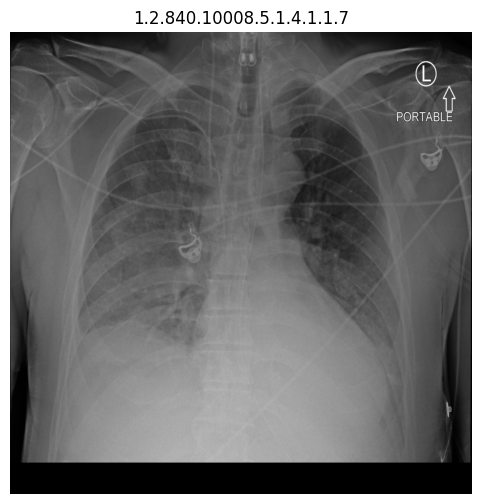

In [8]:
# Example 3: Display DICOM image

# Extact path names
zip_filename=ZIP_FILENAME
folder_root =  zip_filename.replace('.zip', '')
data_root = zip_filename.replace('_data.zip', '')
image_folder = data_root+"_train_images/"

# Generate path to image folder
path ="./"+folder_root+"/"+image_folder

print(path)

image_paths = {
    "Normal": path+"c1edf42b-5958-47ff-a1e7-4f23d99583ba.dcm",
    "No Lung Opacity/Not Normal": path+"00322d4d-1c29-4943-afc9-b6754be640eb.dcm",
    "Lung Opacity": path+"c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.dcm"
}

# Set display size
figsize = (6, 6)

# Ask the user which class they want to see
user_choice = input("Enter the class type to see (Normal, 'No Lung Opacity/Not Normal', or Lung Opacity): ")

# Ensure the user inputs a valid choice
while user_choice not in image_paths:
    print("Invalid choice. Please enter one of the specified class types.")
    user_choice = input("Enter the class type to see (Normal, 'No Lung Opacity/Not Normal', or Lung Opacity): ")

# Display the selected image
img_dir = image_paths[user_choice]
display_dicom_image(img_dir, figsize)

If the code is correct you should see something _similar_ to the following output depending upon your input choice.

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_4_image14A.png)

### Example 4: Select Image Number

The code in the cell below allows the user to select **how many images** that were downloaded such be used in the analysis. The `pna_data` file has a total of `9937` images that are `1024x1024x3` pixels in size. Let's calculate how much System RAM would be necessary to store all `9937` of these DICOM images in memory:

To determine the size of a data file that contains 9937 images, each with dimensions 1024x1024 and using 3 color channels (RGB), we can follow these steps:

1. **Calculate the size of one image:**
   - Each pixel is represented by 3 bytes (one for each color channel).
   - The image resolution is 1024 x 1024 pixels.
   - Therefore, the size of one image in bytes is:
     $
     1024 \times 1024 \times 3 = 3,145,728 \text{ bytes}
     $

2. **Calculate the total size for all images:**
   - There are 9937 such images in the data file.
   - Therefore, the total size of the data file in bytes is:
     $
     9937 \times 3,145,728 = 31,260,740,616 \text{ bytes}
     $

To put this into perspective, we can convert it to more human-readable units:

- **In kilobytes (KB):**
  $
  31,260,740,616 \div 1024 = 30,528,067 \text{ KB}
  $

- **In megabytes (MB):**
  $
  30,528,067 \div 1024 = 30,007.9 \text{ MB}
  $

- **In gigabytes (GB):**
  $
  30,007.9 \div 1024 = 29.8 \text{ GB}
  $

Therefore, the size of the data file would be approximately **29.8 gigabytes** if it contained 9937 images, each with dimensions `1024x1024` and using 3 color channels. That would require a large amount of system memory just to store the image data **BEFORE** it can transferred to the GPU. Even with Colab's `High-RAM` option enabled, it is pretty easy to generate an **Out Of Memory (OOM)** error and crash the notebook!


In [10]:
# Example 4: Select Image Number

MAX_FILES=-1  # -1 means all image files
SET_SEED=586

# generate image_df
print(f"Generating DICOM images with seed={SET_SEED}")
img_df, dropped = load_and_preprocess_data(
    data_dir='./pna_data',
    max_files=MAX_FILES,         # 10_000,
    seed=SET_SEED,
    log_dropped=True
)
display(img_df)

Generating DICOM images with seed=586
Dropped 28292 rows (no valid DICOM).


,patientId,class,x,y,width,height,Target,file_path
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,/content/pna_data/pna_train_images/00313ee0-9e...
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,/content/pna_data/pna_train_images/00322d4d-1c...
18,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity,288.0,322.0,94.0,135.0,1,/content/pna_data/pna_train_images/00aecb01-a1...
19,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity,547.0,299.0,119.0,165.0,1,/content/pna_data/pna_train_images/00aecb01-a1...
20,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity,288.0,322.0,94.0,135.0,1,/content/pna_data/pna_train_images/00aecb01-a1...
...,...,...,...,...,...,...,...,...
37619,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,609.0,464.0,240.0,284.0,1,/content/pna_data/pna_train_images/c1ec14ff-f6...
37620,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,185.0,298.0,228.0,379.0,1,/content/pna_data/pna_train_images/c1ec14ff-f6...
37621,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,609.0,464.0,240.0,284.0,1,/content/pna_data/pna_train_images/c1ec14ff-f6...
37622,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,185.0,298.0,228.0,379.0,1,/content/pna_data/pna_train_images/c1ec14ff-f6...


If the code is correct you should see something _similar_ to the following output depending upon your input choice.

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_4_image15A.png)

### Example 5: Generate File Paths for Data Loader

The code in the cell below generates two very important Python `lists`.
As will be explained below, these file paths will tell the special data loader where to find the X-values (images) and y-values (Targets).


In [11]:
# Example 5: Generate File Paths for Data Loader

# Build the two lists that the rest of your pipeline expects ----
file_paths_list = img_df['file_path'].tolist()
labels_list     = img_df['Target'].astype(int).tolist()

# --- Show first 3 items in lists -------------------------------
for i in range(3):
    print(f"X-value {i}: {file_paths_list[i]}")
    print(f"y-value {i}:     {labels_list[i]}\n")

X-value 0: /content/pna_data/pna_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm
y-value 0:     0

X-value 1: /content/pna_data/pna_train_images/00322d4d-1c29-4943-afc9-b6754be640eb.dcm
y-value 1:     0

X-value 2: /content/pna_data/pna_train_images/00aecb01-a116-45a2-956c-08d2fa55433f.dcm
y-value 2:     1



If the code is correct you should see something _similar_ to the following output depending upon your input choice.

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_4_image16A.png)

At first this output might appear rather odd, especially the `X-value`. Instead of actual DICOM images, the X-values are the _path names_ to each image. This quite different than in your previous lessons where the X-values were numerical values in a `Numpy array`. The reason for generating path names and not a numerical array will be explained below.

------------------------------------------------

### **_Lazy Loading_: The Secrete of Analyzing Large Image Datafiles**

In this lesson we didn't generate a **huge NumPy array** to hold the image data; instead, we are using **filenames** and **_lazy loading_** techniques to feed the data loader. This approach significantly reduces memory usage because it avoids loading entire image arrays into `System RAM` at once. Instead, images are loaded on-the-fly as needed by the training process, which can be **much more memory efficient** for large datasets.

Here's a breakdown of why _lazy loading_ is superior to generating an Numpy array in system RAM:

* **Memory Efficiency:** By using filenames and a data loader that reads images on-the-fly, the code avoids consuming nearly 30 GB of RAM all at once. This is particularly important when dealing with large datasets or high-resolution images, where each image can consume substantial memory. Lazy loading defers the loading of image data until it's actually needed for processing, thus reducing peak memory usage.

* **Scalability:** This approach scales better with larger datasets because you don't need to allocate a massive amount of RAM upfront. You only load as much data into memory as your application needs at any given time, which is ideal for scenarios where the dataset size far exceeds available system RAM.

* **Efficiency:** Lazy loading can also improve processing efficiency by reducing I/O bottlenecks. When training a model, you often need to read and preprocess images multiple times (e.g., during each epoch of training). This repeated reading from disk is more efficiently managed when the data isn't fully loaded into memory at once.

* **Simplicity:** The code can be simpler and cleaner because it doesn't involve managing large in-memory arrays. Instead, it relies on existing libraries for efficient file handling and data loading, which often have built-in optimizations for performance.

In summary, the **lazy loading technique is superior** to loading all images into a `NumPy` array due to its memory efficiency, scalability, improved processing efficiency, and simplicity. This approach allows you to work with large datasets that would otherwise be impractical to handle using traditional methods that require massive amounts of RAM.




-------------------------------------------------

### Create Data Functions



The code in the below creates one **class** and several **functions** that will perform a variety of tasks in preparation for train our `ResNet101` neural network.

Here is a brief summary of the activities performed by the most important functions.

------------------------------------------------
* class: **DicomImageDataset(Dataset)**
This code defines a custom dataset class named **DicomImageDataset** for handling DICOM image files. The class is designed to read and process these images along with their corresponding labels. Here's a brief synopsis of its functionality:

* * **Initialization (__init__):** The constructor takes three parameters: file_paths, labels, and an optional transform. It asserts that the lengths of file_paths and labels are equal, as each file path must have a corresponding label. The class initializes these inputs into instance variables for later use.

* * **Length (__len__):** This method returns the total number of items in the dataset, which is determined by the length of file_paths. It represents how many images are available in the dataset.

* * **Get Item (__getitem__):** This method retrieves an item from the dataset at a specified index (idx). It first extracts the file path and label.

--------------------------------------------

* def function: **build_loaders( )**
This function is designed to create train/validation DataLoaders from a dataset of DICOM images. It takes several parameters including file paths and labels, as well as optional settings for batch size, validation split ratio, number of worker threads, and whether memory should be pinned during data loading. The function returns two DataLoader objects: one for the training set and one for the validation set.

* * **Parameters:**
    - `file_paths`: List of absolute paths to the DICOM files.
    - `labels`: Corresponding integer labels for each file path.
    - `batch_size` (default: BATCH_SIZE): Number of samples per batch in the DataLoader.
    - `val_split` (default: VAL_SPLIT): Proportion of the dataset to include in the validation set.
    - `num_workers` (default: 0): Number of subprocesses to use for data loading.
    - `pin_memory` (default: False): Whether to copy tensors into CUDA pinned memory before returning them.

* * **Transforms:**
    - Two transformations are obtained based on whether the dataset is for training or validation using the `get_transform` function. The training transformation includes data augmentation, while the validation transformation does not.

* * **Dataset Splitting:**
    - A full dataset object is created from the provided file paths and labels with the training transform.
    - The size of the train and validation sets is calculated based on the `val_split` parameter.
    - The dataset is split into a training set (`train_ds`) and a validation set (`val_ds`) using the `random_split` function.

* * **Validation Transform Override:**
    - The transform for the validation set (`val_ds`) is overridden to use the validation transformation obtained earlier.

* * **DataLoaders:**
    - Train and validation DataLoader objects are created with the specified batch size, shuffling, number of worker threads, and pinned memory settings.

* * **Returns:**
    - A tuple containing two DataLoader objects: `train_loader` for the training set and `val_loader` for the validation set.
--------------------------------------------

* def function: **get_resnet101( )**

This function creates and returns a ResNet-101 model tailored for classification tasks, optionally with additional regularization layers such as dropout or DropBlock, followed by a final linear layer. The model can be initialized with pre-trained weights on ImageNet.

* * **Parameters:**
    - `num_classes`: Number of output classes the model should predict.
    - `pretrained` (default=True): If True, initializes the model with pre-trained weights from ImageNet.
    - `device` (default=None): Specifies the device (CPU or GPU) where the model will be loaded and run. If None, it automatically selects based on availability.
    - `name` (default=None): Optional human-friendly name for the model, which is stored as `model.name`.
    - `dropout_p` (default=0.5): Dropout probability to apply after the backbone layers.
    - `dropblock_size` (default=5): Size of the spatial block to drop using DropBlock regularization. This parameter is only used if `dropblock_prob` is greater than 0.
    - `dropblock_prob` (default=0.1): Probability that a block is dropped during training with DropBlock regularization.
    - `add_norm` (default=False): If True, adds a BatchNorm layer after the backbone layers.

* * **Device Handling:**
    - If no device is specified, the function will automatically select either CPU or GPU based on whether CUDA is available.

* * **Model Initialization:**
    - The model starts by loading the ResNet-101 architecture, optionally using pre-trained weights from ImageNet.
    - DropBlock regularization is applied to the final layer of the backbone if `dropblock_size` and `dropblock_prob` are provided.
    - The fully connected (fc) layer of the original ResNet-101 is replaced with an identity mapping since we will add our own classification head.

* * **Model Tail:**
    - Additional layers such as BatchNorm and Dropout can be added based on the parameters provided.
    - A new linear layer is appended to serve as the final classification layer for `num_classes`.
    - The entire sequence of layers is moved to the specified device and returned as a single sequential model.
    - If a name is provided, it is assigned to the model's `name` attribute for identification purposes.

* * **Returns:**
    - A PyTorch nn.Module object representing the ResNet-101 backbone with optional

--------------------------------------------

* def function: **train_one_epoch( )**

This function is designed to train a neural network model for one complete pass through the training dataset. It takes several parameters including the model itself, a DataLoader object for the training data, a loss criterion (e.g., CrossEntropyLoss), an optimizer (e.g., Adam or SGD), a device (CPU or GPU) on which to perform computations, and optionally a `model_name` for bookkeeping purposes. The function returns the average loss per sample over the epoch.

* * **Parameters:**
    - `model`: Neural network model to be trained.
    - `loader`: DataLoader object containing the training data.
    - `criterion`: Loss criterion (e.g., CrossEntropyLoss) for computing the loss between predictions and targets.
    - `optimizer`: Optimizer (e.g., Adam or SGD) used to update model parameters.
    - `device`: Device (CPU or GPU) on which to perform computations.
    - `model_name` (optional): A string to be stored as the model's name attribute for bookkeeping purposes.

* * **Bookkeeping:**
    - If a `model_name` is provided, it is assigned to `model.name`. This allows tracking and identification of the model during training or later inspection.

* * **Training Process:**
    - The model is set to train mode using `model.train()`.
    - A variable `epoch_loss` is initialized to accumulate the total loss over the epoch.
    - Iterating through the DataLoader, for each batch of images (`imgs`) and targets (ground truth labels), the following steps are performed:
        - Move both `imgs` and `targets` to the specified device (CPU or GPU).
        - Zero out the gradients from the previous step using `optimizer.zero_grad()`.
        - Forward pass through the model to get predictions (`outputs`).
        - Compute the loss between `outputs` and `targets` using the provided criterion.
        - Backward pass to compute gradients of the loss with respect to model parameters.
        - Update model parameters using the optimizer's step function.
        - Accumulate the batch loss to `epoch_loss`.
    - After all batches are processed, calculate and return the average epoch loss per sample (`epoch_loss / len(loader.dataset)`).
--------------------------------------------

* def function: **run_training_lazy( )**

This function orchestrates the training of a neural network model using a lazy loading approach. It handles data loading, model creation, loss computation, optimization, learning rate scheduling, and early stopping. The function is designed to be flexible with various hyperparameters and can optionally use GPU acceleration if available.

* * **Parameters:**
    - `file_paths`: List of file paths to the training images.
    - `labels`: Corresponding list of integer labels for each image.
    - `num_epochs` (default: NUM_EPOCHS): Number of epochs to train the model.
    - `batch_size` (default: BATCH_SIZE): Number of samples per batch in the DataLoader.
    - `lr` (default: LEARNING_RATE): Learning rate for the optimizer.
    - `weight_decay` (default: WEIGHT_DECAY): L2 regularization strength.
    - `patience` (default: PATIENCE): Number of epochs with no improvement after which training will be stopped.
    - `val_split` (default: VAL_SPLIT): Fraction of the dataset to use as validation set.
    - `early_stop` (default: EARLY_STOPPING): Boolean flag indicating whether to stop early if validation loss does not improve.
    - `device` (default: None): Device (CPU or GPU) where the model will be loaded and run. If None, it automatically selects based on availability.

* * **Device Handling:**
    - If no device is specified, the function will automatically select either CPU or GPU based on whether CUDA is available.

* * **Data Loaders:**
    - `train_loader` and `val_loader` are created using the `build_loaders` function with parameters for batch size, validation split, number of worker threads, and pinned memory.

* * **Model Initialization:**
    - A ResNet-101 model is instantiated with specified hyperparameters such as dropout probabilities, normalization addition, and a custom name. The number of classes (`num_classes`) is set based on the maximum label value plus one.

* * **Loss/Optimizer/Scheduler:**
    - CrossEntropyLoss is used for loss computation with optional label smoothing.
    - AdamW optimizer is initialized with specified learning rate and weight decay.
    - CosineAnnealingLR scheduler adjusts the learning rate during training.

* * **Early Stopping:**
    - A best model checkpoint is maintained to revert to if validation performance does not improve over a set number of epochs (`patience`).

* * **Training Loop:**
    - The function iterates through each epoch, performing both training and validation phases:
        - During training, it computes gradients, updates weights, and accumulates loss.
        - During validation, it evaluates the model without updating parameters, accumulating loss and accuracy metrics.
    - Learning rate is adjusted using the scheduler at the end of each epoch.
    - Early stopping is implemented to halt training if performance does not improve for a specified number of epochs.

* * **Final Report:**
    - After training, the best performing model (based on validation loss) is reported along with its metrics.
    - Memory cache is cleared and garbage collected at the end of training to free up resources.

* * **Returns:**
    - A dictionary containing the training and validation losses, accuracies, as well as the best epoch and associated metrics.
--------------------------------------------

* def function: **plot_train_hist( )**

This function generates a two-panel plot to visualize the training and validation performance metrics over epochs. The left panel displays accuracy trends during training and validation, while the right panel shows loss trends. Optionally, it highlights the epoch with the best model performance using a vertical red dashed line.

* * **Parameters:**
    - `history`: A dictionary containing keys for 'train_acc', 'val_acc', 'train_loss', and 'val_loss'. These keys should map to lists or arrays of metrics recorded over each epoch during training.

* * **Plot Layout:**
    - The plot consists of two subplots arranged horizontally: one on the left for accuracy, and one on the right for loss. Each subplot is configured with appropriate labels, titles, and limits as follows:
        - Left panel (accuracy):
            - Plots training and validation accuracy curves.
            - Sets x-axis label to "Epoch", y-axis label to "Accuracy", and ensures the y-axis range is between 0 and 1 for better interpretability of the metrics.
            - The legend indicates which curve corresponds to train and validation accuracy, positioned at the bottom right.
        - Right panel (loss):
            - Plots training and validation loss curves.
            - Sets x-axis label to "Epoch", y-axis label to "Loss".
            - Ensures the y-axis starts from 0 for better visual differentiation of trends in the loss values. The top limit is left to matplotlib's default setting, which generally adjusts it based on the data range.
            - The legend indicates which curve corresponds to train and validation loss, positioned at the top right.

* * **Highlight Best Epoch:**
    - If a 'best_epoch' key exists in the `history` dictionary, indicating that early stopping was applied during training, a vertical red dashed line is drawn at this epoch on both subplots to highlight it as the optimal point where performance started improving significantly.
    - The legend for each axis is updated dynamically to include the "Best epoch" label if not already present.

* * **Figure Title and Layout:**
    - A main title "Training History" is added at the top of the figure, ensuring it does not overlap with subplots.
    - `fig.tight_layout(rect=[0, 0, 1, 0.95])` adjusts the layout to ensure all elements fit well without overlapping, leaving some space for the title.

* * **Display the Plot:**
    - The plot is displayed using `plt.show()`, which opens a window showing both subplots side by side.

In [13]:
# Create Data Functions

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from tqdm import tqdm
import torch.nn.functional as F
import copy
from typing import Optional

# Set Import Variables Here!
NUM_EPOCHS: int = 50
BATCH_SIZE: int = 64  # Reduced for memory management
IMG_SIZE: int = 512  # Standard size for ResNet101
LEARNING_RATE: float = 0.0010
WEIGHT_DECAY: float  = 0.0010
VAL_SPLIT: float = 0.2
PATIENCE = 5
EARLY_STOPPING = True

# ------------------------------------------
# Custom Dataset Class with Transforms
# ------------------------------------------
class DicomImageDataset(Dataset):
    """
    Load a DICOM image from disk and return (image_tensor, label).

    Parameters
    ----------
    file_paths : list[str]
        Absolute paths to the DICOM files.
    labels    : list[int]
        Integer labels that align with `file_paths`.
    transform : callable | None
        Optional transform that receives the `pydicom.dataset.FileDataset`
        and returns a torch tensor.
    """

    def __init__(self, file_paths, labels, transform=None):
        assert len(file_paths) == len(labels), \
            f"file_paths ({len(file_paths)}) != labels ({len(labels)})"
        self.file_paths = file_paths
        self.labels    = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path  = self.file_paths[idx]
        label = self.labels[idx]

        try:
            dicom_img = pydicom.dcmread(path, force=True)   # <-- fails on corrupt files
        except Exception as exc:
            # Raise a RuntimeError that will be caught by the caller.
            raise RuntimeError(f"Could not read DICOM at {path!r}: {exc}")

        # Convert DICOM pixel array to proper format for transforms
        if hasattr(dicom_img, 'pixel_array'):
            img_array = dicom_img.pixel_array

            # Handle different data types and normalize
            if img_array.dtype != np.uint8:
                if img_array.max() > 1.0:
                    img_array = ((img_array - img_array.min()) /
                               (img_array.max() - img_array.min()) * 255).astype(np.uint8)
                else:
                    img_array = (img_array * 255).astype(np.uint8)

            # Convert to PIL Image for transforms
            from PIL import Image
            if len(img_array.shape) == 2:
                # Single channel - convert to RGB by duplicating
                pil_img = Image.fromarray(img_array, mode='L')
                # Convert grayscale to RGB
                pil_img = pil_img.convert('RGB')
            else:
                # Already multi-channel, convert to RGB if needed
                pil_img = Image.fromarray(img_array)
                if pil_img.mode != 'RGB':
                    pil_img = pil_img.convert('RGB')

            if self.transform is not None:
                img = self.transform(pil_img)
            else:
                # Convert to tensor if no transform
                img = torch.tensor(img_array, dtype=torch.float32)
                if len(img.shape) == 2:
                    img = img.unsqueeze(0)  # Add channel dimension
        else:
            raise RuntimeError(f"No pixel array in DICOM file {path!r}")

        return img, label


# ------------------------------------------
# Helper: Check file paths
# ------------------------------------------
def filter_valid_dicom(paths, labels, max_attempts=5):
    """
    Returns a pair (valid_paths, valid_labels) that only contains files that
    can be successfully read with pydicom.
    """
    valid_paths, valid_labels = [], []
    for p, l in zip(paths, labels):
        try:
            pydicom.dcmread(p, force=True)
        except Exception as exc:
            # Log and skip
            print(f"⚠️  Skipping {p!r}: {exc}")
            continue
        valid_paths.append(p)
        valid_labels.append(l)

    if not valid_paths:
        raise RuntimeError("All DICOM files failed to load – dataset is empty.")
    return valid_paths, valid_labels

# ------------------------------------------
# Helper: Build transforms
# ------------------------------------------
def get_transform(
    img_size=IMG_SIZE,
    is_train: bool = True,
    crop_size=IMG_SIZE,
    h_flip: bool = True,
    augment: bool = False
) -> transforms.Compose:
    """
    Returns a torchvision transform chain.
    """
    if is_train:
        transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomResizedCrop(crop_size) if augment else transforms.CenterCrop(crop_size),
            transforms.RandomHorizontalFlip() if h_flip else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),  # This will convert to float and normalize [0,1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    else:  # eval / test
        transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    return transform

# ------------------------------------------------------------------
# Helper: Build loaders from lazy datasets
# ------------------------------------------------------------------
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet101_Weights
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import gc

def build_loaders(
    file_paths, labels,
    batch_size: int = BATCH_SIZE,
    val_split:  float = VAL_SPLIT,
    num_workers: int = 0,
    pin_memory: bool = False
):
    """Create train/validation DataLoaders from lazy dataset."""
    transform_train = get_transform(is_train=True)
    transform_val   = get_transform(is_train=False)

    full_dataset = DicomImageDataset(file_paths, labels, transform=transform_train)

    train_size = int(len(full_dataset) * (1.0 - val_split))
    val_size   = len(full_dataset) - train_size
    train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

    # Override validation transform
    val_ds.dataset.transform = transform_val

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=pin_memory
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory
    )
    return train_loader, val_loader

# ------------------------------------------
# Training loop
# ------------------------------------------
from tqdm import tqdm

def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    model_name: str | None = None,          # NEW
) -> float:
    """
    Train a single epoch.  The new ``model_name`` argument is *only* for
    bookkeeping – it is stored on the model as ``model.name``.
    """
    if model_name is not None:
        # Store the name for later inspection
        model.name = model_name

    model.train()
    epoch_loss = 0.0

    for imgs, targets in tqdm(loader, desc="Training", leave=False):
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * imgs.size(0)

    return epoch_loss / len(loader.dataset)


# --------------------------------------------
# Measure validation loss during training
# --------------------------------------------
def validate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> tuple[float, float]:
    model.eval()
    epoch_loss = 0.0
    correct = 0

    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc="Validation", leave=False):
            imgs, targets = imgs.to(device), targets.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, targets)

            epoch_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()

    val_loss = epoch_loss / len(loader.dataset)
    val_acc = correct / len(loader.dataset)
    return val_loss, val_acc

import torch
import torch.nn as nn
from torchvision import models
from dropblock import DropBlock2D  # pip install dropblock

# --------------------------------------------
# Create ResNet model
# --------------------------------------------
def get_resnet101(
    num_classes: int,
    pretrained: bool = True,
    device: torch.device | None = None,
    name: str | None = None,
    dropout_p: float = 0.5,
    dropblock_size: int | None = 5,
    dropblock_prob: float | None = 0.1,
    add_norm: bool = False,
    **kwargs,
) -> nn.Module:
    """
    Return a ResNet‑101 backbone followed by optional regularisers
    and a final linear head.

    Parameters
    ----------
    num_classes : int
        Number of output classes.
    pretrained : bool, default=True
        Load ImageNet pre‑trained weights.
    device : torch.device | None, default=None
        Device to move the model onto.
    name : str | None, default=None
        Optional human‑friendly name (`model.name = name`).
    dropout_p : float, default=0.5
        Drop‑out probability *after* the backbone.
    dropblock_size : int | None, default=5
        Size of the spatial block to drop (used only if dropblock_prob > 0).
    dropblock_prob : float | None, default=0.1
        Probability that a block is dropped.
    add_norm : bool, default=False
        Add a 1‑D BatchNorm layer *after* the backbone.

    Returns
    -------
    nn.Module
        Sequential model: `backbone → (optional layers) → Linear`
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the pre‑trained ResNet‑101
    backbone = models.resnet101(
        weights=models.ResNet101_Weights.DEFAULT if pretrained else None
    )

    # Insert DropBlock *before* the global avg‑pool
    if dropblock_size is not None and dropblock_prob is not None:
        # The final residual block produces a 4‑D tensor (b, 2048, 7, 7)
        backbone.layer4 = nn.Sequential(
            backbone.layer4,
            DropBlock2D(block_size=dropblock_size, drop_prob=dropblock_prob)
        )

    # Make the backbone output a 1‑D vector (2048‑dim)
    in_features = backbone.fc.in_features
    backbone.fc = nn.Identity()

    # Build the tail
    layers: list[nn.Module] = [backbone]

    if add_norm:
        layers.append(nn.BatchNorm1d(in_features))

    if dropout_p > 0.0:
        layers.append(nn.Dropout(p=dropout_p))

    # Final classification head
    layers.append(nn.Linear(in_features, num_classes))

    # Stack everything
    model = nn.Sequential(*layers).to(device)

    if name is not None:
        model.name = name

    return model


# ------------------------------------------
# Training routine
# ------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision import models
import copy, gc

def run_training_lazy(
    file_paths: list[str],
    labels:     list[int],
    num_epochs: int   = NUM_EPOCHS,
    batch_size: int   = BATCH_SIZE,
    lr:          float = LEARNING_RATE,
    weight_decay:float = WEIGHT_DECAY,
    patience:    int   = PATIENCE,
    val_split:   float = VAL_SPLIT,
    early_stop:  bool  = EARLY_STOPPING,
    device:      torch.device = None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ----- Loaders
    train_loader, val_loader = build_loaders(
        file_paths, labels,
        batch_size=batch_size,
        val_split=val_split,
        num_workers=0,
        pin_memory=False
    )

    # ----- Model
    num_classes = max(labels) + 1
    # model = get_resnet101(num_classes=num_classes, pretrained=True, device=device)
    model = get_resnet101(
    num_classes=10,
    pretrained=True,
    dropout_p=0.5,
    dropblock_size=5,
    dropblock_prob=0.1,
    add_norm=True,
    name="resnet101_reg"
)

    # ----- Loss/optimiser/scheduler
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    #optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=num_epochs, eta_min=lr * 0.01
    )

    # ----- Early‑stopping bookkeeping
    best_val_loss = float("inf")
    best_epoch = 0
    best_train_acc = best_val_acc = None
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_without_improve = 0

    # ----- History
    train_losses, val_losses = [], []
    train_accs,   val_accs   = [], []

    # ----- Epoch loop
    for epoch in range(1, num_epochs + 1):
        # training
        model.train()
        epoch_train_loss = 0.0
        correct_train = 0
        n_train = len(train_loader.dataset)

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * xb.size(0)
            preds = torch.argmax(logits, dim=1)
            correct_train += (preds == yb).sum().item()

        epoch_train_loss /= n_train
        epoch_train_acc  = correct_train / n_train

        # validation
        model.eval()
        epoch_val_loss = 0.0
        correct_val = 0
        n_val = len(val_loader.dataset)

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)

                epoch_val_loss += loss.item() * xb.size(0)
                preds = torch.argmax(logits, dim=1)
                correct_val += (preds == yb).sum().item()

        epoch_val_loss /= n_val
        epoch_val_acc  = correct_val / n_val

        # scheduler step
        scheduler.step()

        # early stopping
        if early_stop:
            if epoch_val_loss < best_val_loss - 1e-5:
                best_val_loss = epoch_val_loss
                best_epoch = epoch
                best_train_acc = epoch_train_acc
                best_val_acc   = epoch_val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_without_improve = 0
            else:
                epochs_without_improve += 1

            if epochs_without_improve >= patience:
                print("\nEarly stopping triggered.")
                print(f"Best epoch (before stopping): {best_epoch}")
                print(f"  Train Acc: {best_train_acc:.4f} | Train Loss: {epoch_train_loss:.4f}")
                print(f"  Valid Acc: {best_val_acc:.4f} | Valid Loss: {epoch_val_loss:.4f}\n")
                model.load_state_dict(best_model_wts)
                break

        # log
        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"Train Acc:  {epoch_train_acc:.4f} | Train Loss: {epoch_train_loss:.4f} | "
            f"Val Acc:    {epoch_val_acc:.4f} | Val Loss: {epoch_val_loss:.4f}"
        )

        # history
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

    # final report
    if not early_stop or epochs_without_improve < patience:
        best_epoch = epoch
        best_train_acc = epoch_train_acc
        best_val_acc   = epoch_val_acc
        best_val_loss  = epoch_val_loss

    print("\nTraining finished.")
    print(f"Best epoch: {best_epoch}")
    print(f"  Train Acc: {best_train_acc:.4f} | Train Loss: {epoch_train_loss:.4f}")
    print(f"  Val   Acc: {best_val_acc:.4f}   | Val   Loss: {epoch_val_loss:.4f}")

    torch.cuda.empty_cache()
    gc.collect()

    return {
        "train_loss": train_losses,
        "train_acc":   train_accs,
        "val_loss":    val_losses,
        "val_acc":     val_accs,
        "best_epoch":  best_epoch,
        "best_train_acc": best_train_acc,
        "best_val_acc":   best_val_acc,
        "best_train_loss": epoch_train_loss,
        "best_val_loss":   epoch_val_loss,
    }


# -------------------------------------------------------------
#  Plot training history
# -------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

def plot_train_hist(history: dict) -> None:
    """
    Plot a two‑panel figure:
        • Left panel – train & val accuracy.
        • Right panel – train & val loss.

    Parameters
    ----------
    history : dict
        Must contain the keys 'train_acc', 'val_acc',
        'train_loss', 'val_loss'.
    """
    # Determine num_epochs from the length of one of the lists (both should be equal)
    num_epochs = len(history["train_acc"])

    epochs = np.arange(1, num_epochs + 1)

    # ---- 2‑panel layout ---------------------------------------
    fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(14, 5))

    # ---------- Left panel – accuracy --------------------------------
    ax_acc.plot(epochs, history["train_acc"], label="train acc", color="C0")
    ax_acc.plot(epochs, history["val_acc"],   label="val acc",   color="C1")
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.set_ylim(0, 1)
    ax_acc.legend(loc="lower right")
    ax_acc.set_title("Accuracy")

    # ---------- Right panel – loss ------------------------------------
    ax_loss.plot(epochs, history["train_loss"], label="train loss", color="C2")
    ax_loss.plot(epochs, history["val_loss"],   label="val loss",   color="C3")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.set_ylim(bottom=0)        # let matplotlib decide the top limit
    ax_loss.legend(loc="upper right")
    ax_loss.set_title("Loss")

    # ---------- Vertical line at best epoch ------------------------
    if "best_epoch" in history:
        best_epoch = history["best_epoch"]
        # Draw the line on both axes
        for ax in (ax_acc, ax_loss):
            ax.axvline(
                best_epoch, color="red",
                linestyle="--", linewidth=1.5,
                label="Best epoch"
                )
        # Update legend to include the new label (only once)
        # The 'best_epoch' label is already added in the loop; we simply
        # force the legend to re‑compute.
        ax_acc.legend(loc="lower right")
        ax_loss.legend(loc="upper right")

    # ---------- Figure title -----------------------------------------
    fig.suptitle("Training History", fontsize=16)

    # Keep the suptitle separate from the sub‑plots
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    plt.show()



### Setup Device

The code in the cell below double-checks to see if there is a Nvidia GPU available to PyTorch to train the neural network.  The code then issues a warning if no GPU is available.

In [20]:
# Setup device

import torch

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device("cuda"):
    print(f"Using device: {device} for neural network training")
elif device == torch.device("cpu"):
   print(f"WARNING: While this code can run on a CPU, it will take many hours to run a single epoch!")
else:
  print("No device found!")

Using device: cuda for neural network training


If the code is correct and you are using a GPU, you should see the following output

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_4_image19A.png)


### Example 6: Run Training

This code snippet initiates the training process for a classification model, measuring and printing the total elapsed time taken to complete the training across a specified number of epochs (NUM_EPOCHS).

The key steps involved are:

* **Start Training Notification:** It prints a message indicating that the training is starting for the given number of epochs, along with other relevant details such as batch size and learning rate.

* **Time Measurement:** It captures the current time before commencing the training using time.time() to serve as the start time. This will be used later to calculate the total elapsed time during and after the training process.

* **Training Execution:** The function `run_training_lazy` is called with parameters for file paths, labels, epochs, batch size, learning rate, weight decay, patience (for early stopping), validation split fraction, and a flag indicating whether to use early stopping. This function performs the actual training of the model using these inputs. The suffix `lazy` refers to fact that it is a "lazy" or "delayed evaluation" function. In programming, a `lazy function` is one that defers the computation or execution of its result until it is explicitly demanded, typically on request (e.g., when accessed). This approach can be particularly useful for optimizing performance by reducing unnecessary operations and improving efficiency, especially with large datasets or complex computations.

* **End Time Recording:** After the training is complete, it records the current time again using time.time() to calculate the total elapsed time by subtracting the start time from this end time.

* **Elapsed Time Output:** The code prints out the total elapsed time in a human-readable format (hours:minutes:seconds) using the function hms_string(elapsed_time) which likely converts the elapsed seconds into hours, minutes, and seconds for easier readability. This helps users understand how much time was spent on training.

The purpose of this code is to provide user feedback regarding both the progress (training epochs completed so far) and efficiency (total time taken for all epochs), thus aiding in performance monitoring and debugging if needed.

In [16]:
# Run Training

import time

# ------------------------------------------------------------------------
# Start training
# ------------------------------------------------------------------------
print(f"-- Training (classification) is starting for {NUM_EPOCHS} epochs----------------------------")
start_time = time.time()

# Run training
history = run_training_lazy(
    file_paths=file_paths_list,
    labels=labels_list,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    patience=PATIENCE,
    val_split=VAL_SPLIT,
    early_stop=EARLY_STOPPING
)

# Record end time
elapsed_time = time.time() - start_time

# Print elapsed time
print(f"Elapsed time: {hms_string(elapsed_time)}")

-- Training (classification) is starting for 50 epochs----------------------------
Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


100%|██████████| 171M/171M [00:00<00:00, 244MB/s]


Epoch 1/50 | Train Acc:  0.7739 | Train Loss: 1.3057 | Val Acc:    0.7339 | Val Loss: 3.4872
Epoch 2/50 | Train Acc:  0.8336 | Train Loss: 1.0424 | Val Acc:    0.7430 | Val Loss: 3.2348
Epoch 3/50 | Train Acc:  0.8650 | Train Loss: 0.9485 | Val Acc:    0.8613 | Val Loss: 0.8769
Epoch 4/50 | Train Acc:  0.9375 | Train Loss: 0.6987 | Val Acc:    0.8683 | Val Loss: 0.9088
Epoch 5/50 | Train Acc:  0.9823 | Train Loss: 0.6011 | Val Acc:    0.8913 | Val Loss: 0.8262
Epoch 6/50 | Train Acc:  0.9949 | Train Loss: 0.5689 | Val Acc:    0.8919 | Val Loss: 0.8212
Epoch 7/50 | Train Acc:  0.9979 | Train Loss: 0.5538 | Val Acc:    0.8940 | Val Loss: 0.7816
Epoch 8/50 | Train Acc:  0.9991 | Train Loss: 0.5441 | Val Acc:    0.8897 | Val Loss: 0.7776
Epoch 9/50 | Train Acc:  0.9987 | Train Loss: 0.5391 | Val Acc:    0.8999 | Val Loss: 0.7756
Epoch 10/50 | Train Acc:  0.9993 | Train Loss: 0.5337 | Val Acc:    0.8945 | Val Loss: 0.7684
Epoch 11/50 | Train Acc:  0.9992 | Train Loss: 0.5314 | Val Acc:    0

If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_4_image17A.png)


### Example 7: Plot Training History

The code in the cell below generates two graphs. The graph on the left shows the change during each epoch in the model's accuracy in predicting the correct label for each training image (`train_acc`) and for each validation image (`val_acc`) while the graph on the right shows model's loss for each epoch for the training images (`train_loss`) and for the validation images (`val loss`). If the model was stopped early (`EarlyStopping`), a vertical red line indicates the `best epoch`.

It should be noted that `EarlyStopping` is best on the lowest `val_loss` value, not the highest `val_acc` value. There are a variety of reasons for doing it this way which are beyond the scope of this class lesson.

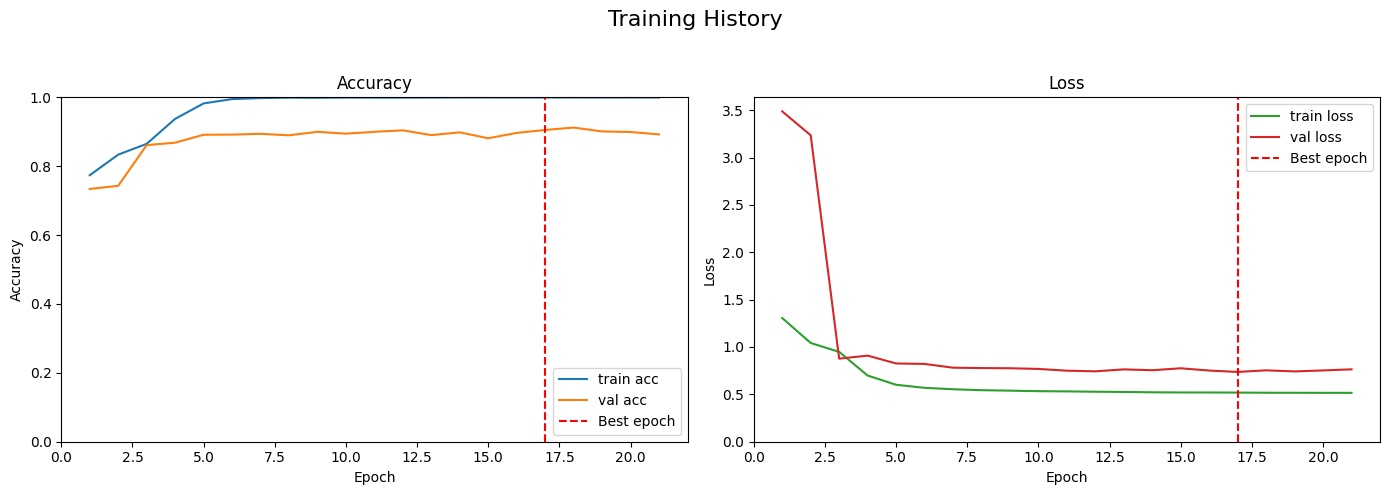

In [18]:
# Example 7: Plot Training History
plot_train_hist(history=history)


If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co/BIO1173/images/class_06/class_06_4_image18A.png)

## **Lesson Turn-in**

When you have completed and run all of the code cells, use the **File --> Print.. --> Save to PDF** to generate a PDF of your Colab notebook. Save your PDF as `Class_06_4.lastname.pdf` where _lastname_ is your last name, and upload the file to Canvas.